<a href="https://colab.research.google.com/github/SudilHasitha/LISA_CNN_ExplainerV3/blob/master/it18059564_Fine_tuning_covid_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Research'

In [ ]:
%cd '/content/drive/MyDrive/Research/'

/content/drive/MyDrive/Research


In [ ]:
# plot validation and training curves seperately
def plot_loss_curves(history):
  ''' returns curves for loss associated with the training and validation phase'''
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.figure(figsize=(10,8)) 
  plt.subplot(1,2,1)
  
  plt.plot(epochs,loss,label="training loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy

  plt.plot(epochs,accuracy,label="training accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
# create a tensorboard callback
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving tensorboard log files to {log_dir}")
  return tensorboard_callback
  

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Research/model_2_check_weights_check/checkpoint.ckpt"

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         monitor="val_accuracy")

In [ ]:
# Import dependencies
import  tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
train_dir = "/content/drive/MyDrive/Research/training/train"
test_dir = "/content/drive/MyDrive/Research/testing/test"
valid_dir = "/content/drive/MyDrive/Research/validating/train"
IMG_SIZE = (224,224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                  labels="inferred",
                                                                  label_mode='categorical',
                                                                  batch_size=32, 
                                                                  image_size=IMG_SIZE,
                                                                 crop_to_aspect_ratio=True)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                labels="inferred",
                                                                label_mode='categorical',
                                                                batch_size=32, 
                                                                image_size=IMG_SIZE,
                                                                crop_to_aspect_ratio=True)

valid_data = tf.keras.preprocessing.image_dataset_from_directory(directory=valid_dir,
                                                                labels="inferred",
                                                                label_mode='categorical',
                                                                batch_size=32, 
                                                                image_size=IMG_SIZE,
                                                                crop_to_aspect_ratio=True)

Found 3500 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 390 files belonging to 2 classes.


In [ ]:
data_augmentation = tf.keras.Sequential([
                                         preprocessing.RandomFlip('horizontal'),
                                         preprocessing.RandomHeight(0.2),
                                         preprocessing.RandomWidth(0.2),
                                         preprocessing.RandomZoom(0.2),
                                         preprocessing.RandomRotation(0.2)
],name="data_augmentation_layer")

In [ ]:
# 1. Create base model with tf.keras.application
base_model = tf.keras.applications.EfficientNetB7(include_top=False)

# 2. Freeze the base model
base_model.trainable = True

# freeze all layers except last 20
for layer in base_model.layers[:-35]:
  layer.trainable = False

# 3. Creates inputs into model
inputs = tf.keras.Input(shape=(224,224,3), name="input_layer")

# Some models need to perform rescaling can prform here except in generator
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = data_augmentation(inputs)

# 4. Pass the inputs to the base model after augmented and don't train
x = base_model(x,training=False) # avoid training batch normalization layers
print(f"shape after passing through base model: {x.shape}")

# 5. Average pool the outputs of the base model (aggregate all important information, reduce no of computations) # create feature vector
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"shape after passing through global avg pooling: {x.shape}")

# 6.create the output layer
outputs = tf.keras.layers.Dense(2,activation="sigmoid",name="output_layer")(x)

# 7. Assemble the model
model_3 = tf.keras.Model(inputs,outputs)

# 8. Compile the model
model_3.compile(loss="binary_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(lr=0.0001),# when fine tuning lower th lr by X10
                     metrics=["accuracy"])

# 9. Fit the model and save the history
# initial_epoch = history_previous_model.epoch[-1] start from the last epoch
model_3_history = model_3.fit(train_data,
                              epochs=20,
                              steps_per_epoch=len(train_data),
                              validation_data=valid_data,
                              validation_steps=len(valid_data),
                              callbacks=[create_tensorboard_callback(dir_name="tranfer_learning",
                                                                    experiment_name="EfficientNet_B7_Functional_API_Baseline"),
                                                                    checkpoint_callback] )

258088960/258076736 [==============================] - 10s 0us/step
shape after passing through base model: (None, None, None, 2560)
shape after passing through global avg pooling: (None, 2560)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Saving tensorboard log files to tranfer_learning/EfficientNet_B7_Functional_API_Baseline/20210824-234721


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20
110/110 [==============================] - 2214s 18s/step - loss: 0.4153 - accuracy: 0.8063 - val_loss: 0.3128 - val_accuracy: 0.8462
Epoch 2/20
110/110 [==============================] - 233s 2s/step - loss: 0.2948 - accuracy: 0.8769 - val_loss: 0.2423 - val_accuracy: 0.9051
Epoch 3/20
110/110 [==============================] - 231s 2s/step - loss: 0.2709 - accuracy: 0.8889 - val_loss: 0.2710 - val_accuracy: 0.8769
Epoch 4/20
110/110 [==============================] - 230s 2s/step - loss: 0.2453 - accuracy: 0.8971 - val_loss: 0.2736 - val_accuracy: 0.8846
Epoch 5/20
110/110 [==============================] - 231s 2s/step - loss: 0.2267 - accuracy: 0.9094 - val_loss: 0.1859 - val_accuracy: 0.9282
Epoch 6/20
110/110 [==============================] - 229s 2s/step - loss: 0.1995 - accuracy: 0.9249 - val_loss: 0.2375 - val_accuracy: 0.9026
Epoch 7/20
110/110 [==============================] - 225s 2s/step - loss: 0.1942 - accuracy: 0.9209 - val_loss: 0.2526 - val_accuracy: 0.90

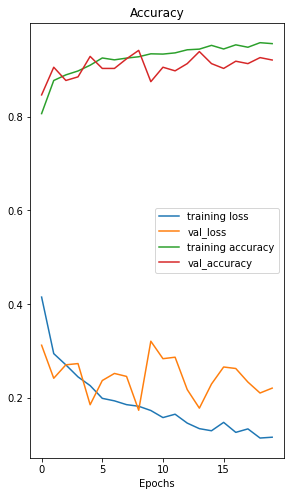

In [ ]:
plot_loss_curves(model_3_history)

In [ ]:
# Evaluating the model
results_model_3 = model_3.evaluate(test_data)
results_model_3

13/13 [==============================] - 250s 6s/step - loss: 0.3009 - accuracy: 0.8950


[0.3009320795536041, 0.8949999809265137]

In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
    --name "inception V2 vs EfficientNet B7" \
    --description "Compare models" \
    --one_shot

2021-06-29 15:45:37.510478: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2

In [ ]:
# check the experiments available
!tensorboard dev list

In [ ]:
# delete the available experiments
# !tensorboard dev delete --experiment_id <id>

In [ ]:
model_3.save("save_model_3")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: save_model_3/assets


In [ ]:
# loaded_model_1 = tf.keras.models.load_model("save_model_3")
# loaded_model_1.evaluate(test_gen)